# Datenanalyse für die Abschlussarbeit: MLOps-Reifegradmodell

## Import der Datei
- **Datei:** Umfrageergebnisse
- **Pakete:** Import der Python-Bibliotheken

In [1]:
file_path = './results.csv'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import scale

# Plot-Konfiguration
plt.style.use('default')  # Verwenden des Standard-Stils
sns.set_theme()  # Seaborn Theme aktivieren

# Unterdrücke Warnungen
import warnings
warnings.filterwarnings('ignore')

## Vorbereitung

### Konfigurationsvariablen

In [3]:
# Fragen für jede Stufe
stages_questions = {
    "Stage A": ["G05Q13", "G05Q15", "G05Q16", "G05Q17", "G05Q18", "G05Q19", "G05Q20"],
    "Stage B": ["G06Q23", "G06Q25", "G06Q27"],
    "Stage C": ["G07Q29", "G07Q30", "G07Q31", "G07Q33", "G07Q34"],
    "Stage D": ["G08Q36", "G08Q37", "G08Q38", "G08Q39", "G08Q40"]
}

# Ordinale Skalenwerte
scale_mapping = {
    "AO01": 0,
    "AO02": 1,
    "AO03": 2,
    "AO04": 3,
    "AO05": 4
}

# Maximalpunkte pro Stage
max_points = {
    "Stage A": 28,  # 7 Fragen × 4 Punkte
    "Stage B": 12,  # 3 Fragen × 4 Punkte
    "Stage C": 20,  # 5 Fragen × 4 Punkte
    "Stage D": 20   # 5 Fragen × 4 Punkte
}

### Hilfsfunktionen

In [4]:
def interpret_correlation(rho):
    """Interpretiert die Stärke der Korrelation"""
    if abs(rho) < 0.3: return "schwach"
    elif abs(rho) < 0.5: return "moderat"
    else: return "stark"

def calculate_confidence_interval(correlation, n, confidence=0.95):
    """Berechnet Konfidenzintervalle für Korrelationen"""
    z = np.arctanh(correlation)
    se = 1/np.sqrt(n-3)
    z_crit = stats.norm.ppf((1 + confidence)/2)
    lo = np.tanh(z-z_crit*se)
    hi = np.tanh(z+z_crit*se)
    return lo, hi

def create_radar_chart(data, stages):
    """Erstellt ein Radar-Chart für die Reifegradstufen"""
    angles = np.linspace(0, 2*np.pi, len(stages), endpoint=False)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='polar')

    values = [data[f'{stage} %'].mean() for stage in stages]
    values += values[:1]
    angles = np.concatenate((angles, [angles[0]]))

    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(stages)
    plt.title('MLOps Reifegradprofil')
    plt.show()

def plot_correlation(x, y, title, xlabel, ylabel):
    """Erstellt ein Streudiagramm mit Regressionslinie"""
    plt.figure(figsize=(10, 6))
    sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5})
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

### Daten laden und bereinigen

In [5]:
# Datei einlesen
data = pd.read_csv(file_path, delimiter=";")

# Datenbereinigung
relevant_data = data.dropna(subset='submitdate')
relevant_data = relevant_data[relevant_data['G01Q01'] != 'AO03']

## Analyse des MLOps-Reifegrads

### Berechnung der Reifegrade

In [6]:
# Punkte für jede Stufe berechnen
for stage, questions in stages_questions.items():
    stage_data = relevant_data[questions].replace(scale_mapping)
    relevant_data[stage + " Points"] = stage_data.sum(axis=1)
    relevant_data[f'{stage} %'] = (relevant_data[f'{stage} Points'] / max_points[stage] * 100).round(2)

# Hauptreifegradstufe bestimmen
def get_main_maturity_stage(row):
    stages_percentages = {stage: row[f'{stage} %'] for stage in stages_questions.keys()}
    return max(stages_percentages.items(), key=lambda x: x[1])[0]

relevant_data['Hauptreifegradstufe'] = relevant_data.apply(get_main_maturity_stage, axis=1)

# Gesamtreifegrad berechnen
def calculate_total_maturity(row):
    weights = {f'{stage} %': 0.25 for stage in stages_questions.keys()}
    return sum(row[stage] * weight for stage, weight in weights.items())

relevant_data['Gesamtreifegrad'] = relevant_data.apply(calculate_total_maturity, axis=1).round(2)

## Reliabilitätsanalyse
Für Kapitel 3.4 Gütekriterien der Untersuchung

Reliabilitätsanalyse der Reifegradstufen:
--------------------------------------------------

Stage A:
Cronbachs α = 0.911 (sehr hoch)
Anzahl Items: 7


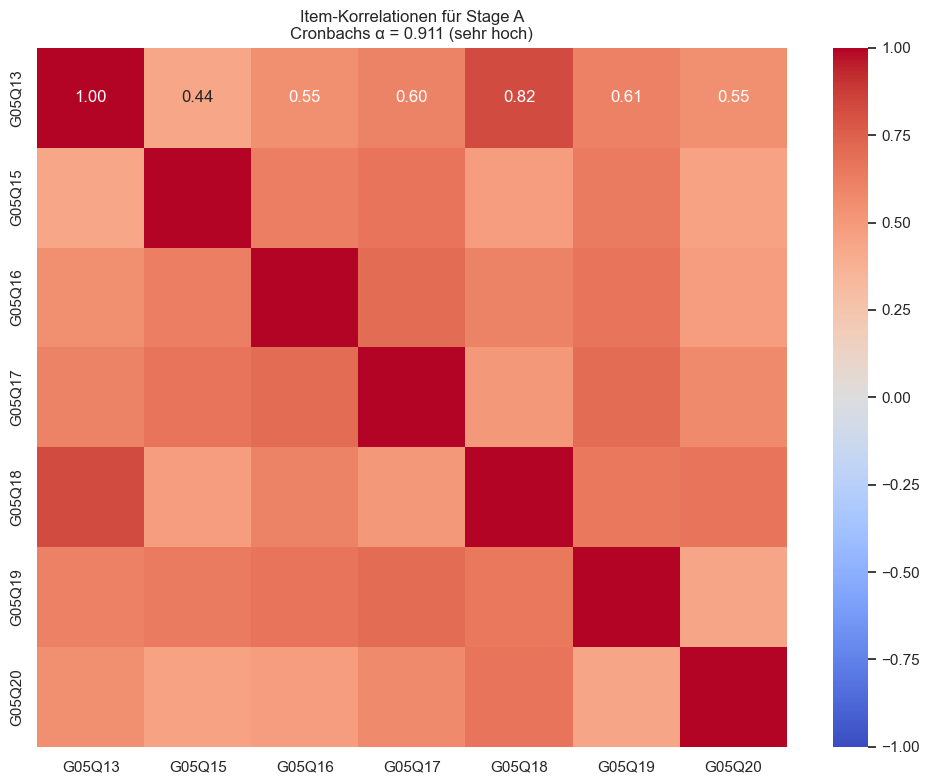


Stage B:
Cronbachs α = 0.839 (sehr gut)
Anzahl Items: 3


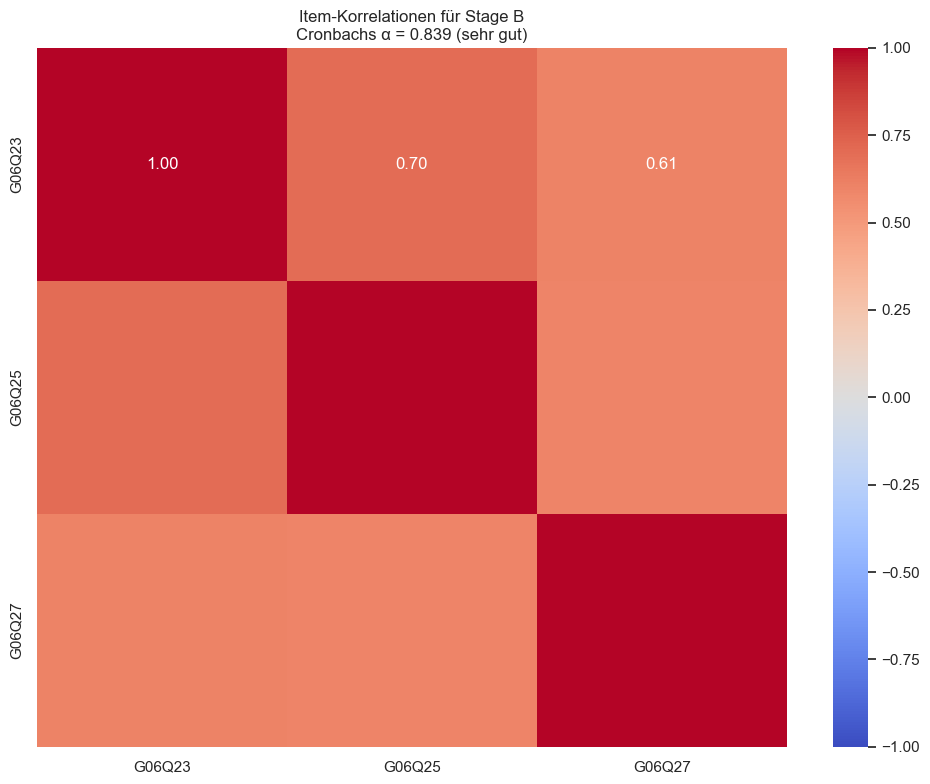


Stage C:
Cronbachs α = 0.924 (sehr hoch)
Anzahl Items: 5


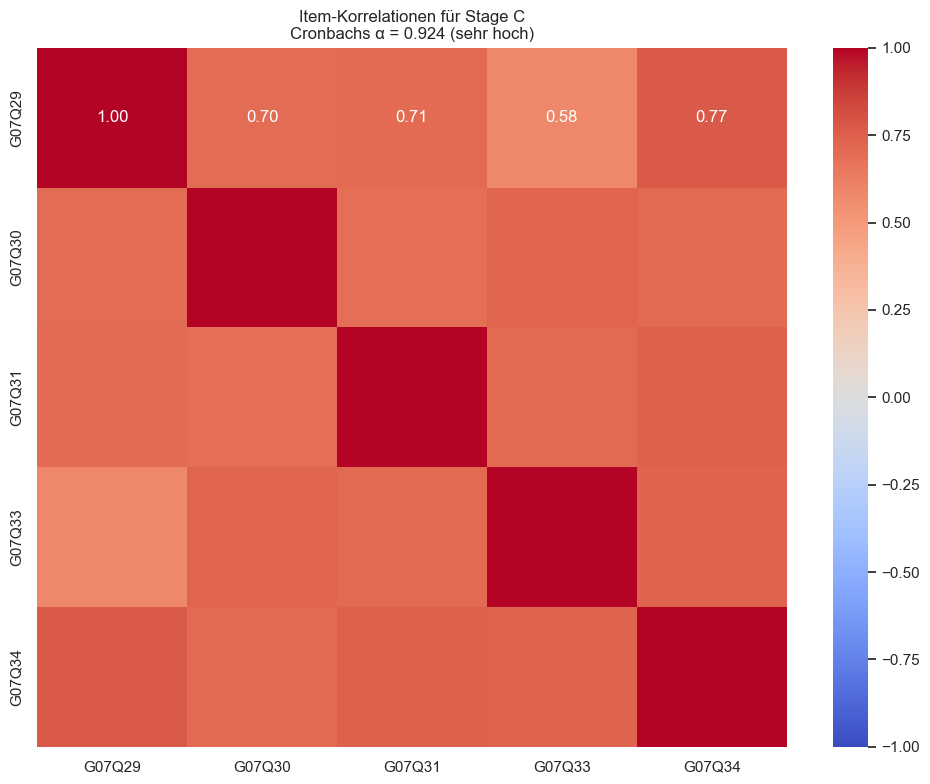


Stage D:
Cronbachs α = 0.909 (sehr hoch)
Anzahl Items: 5


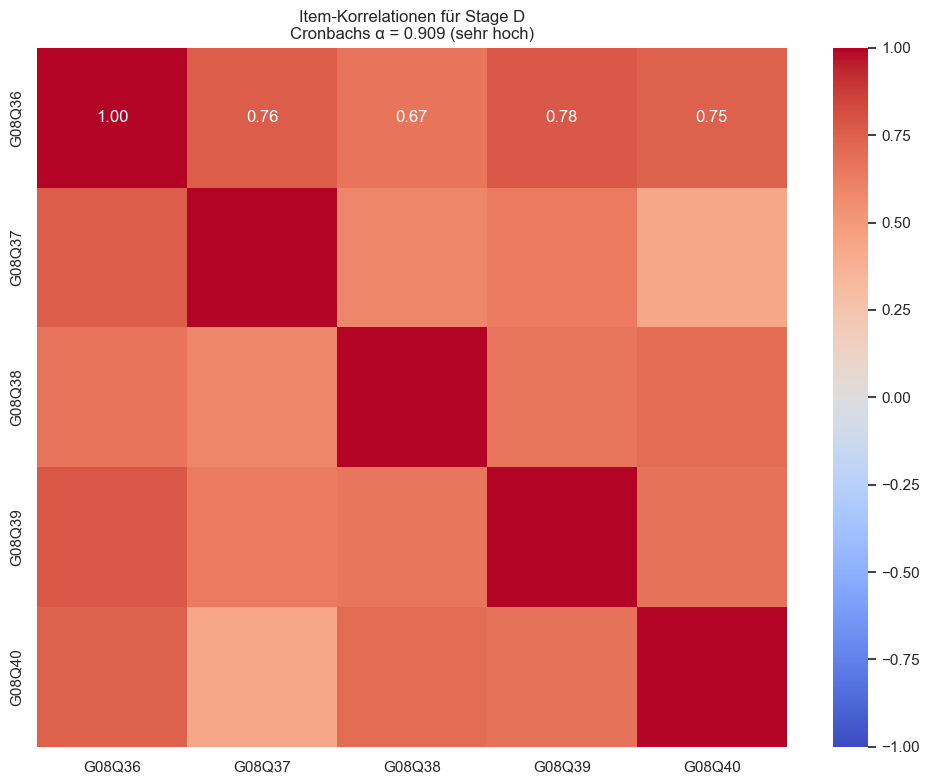


Gesamtübersicht der Reliabilitätsanalyse:
--------------------------------------------------
         Cronbachs Alpha Interpretation  Anzahl Items
Stage A            0.911      sehr hoch             7
Stage B            0.839       sehr gut             3
Stage C            0.924      sehr hoch             5
Stage D            0.909      sehr hoch             5


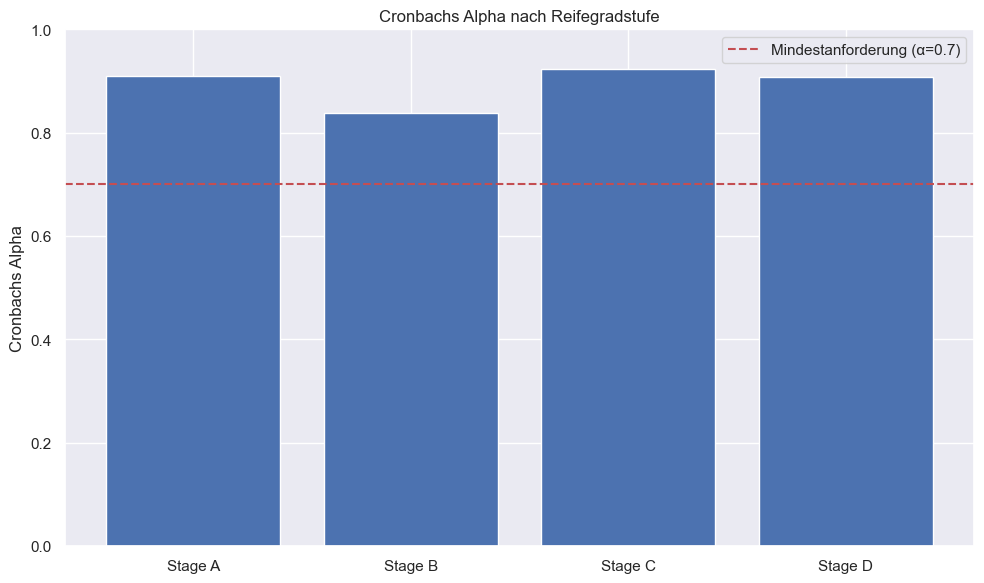

In [7]:
def cronbachs_alpha(items):
    """
    Berechnet Cronbachs Alpha für einen Satz von Items
    """
    items = scale(items)
    items_count = items.shape[1]
    variance_sum = np.sum(np.var(items, axis=0))
    total_var = np.var(np.sum(items, axis=1))
    return (items_count/(items_count-1)) * (1 - variance_sum/total_var)

def interpret_alpha(alpha):
    """
    Interpretiert den Cronbachs Alpha Wert nach DeVellis (2016)
    """
    if alpha > 0.90:
        return "sehr hoch"
    elif alpha >= 0.80:
        return "sehr gut"
    elif alpha >= 0.70:
        return "respektabel"
    elif alpha >= 0.65:
        return "minimal akzeptabel"
    elif alpha >= 0.60:
        return "unerwünscht"
    else:
        return "inakzeptabel"


# Reliabilitätsanalyse für jede Reifegradstufe
print("Reliabilitätsanalyse der Reifegradstufen:")
print("-" * 50)

reliability_results = {}

for stage, questions in stages_questions.items():
    # Daten für die Stage vorbereiten
    items = relevant_data[questions].replace(scale_mapping)

    # Cronbachs Alpha berechnen
    alpha = cronbachs_alpha(items)
    interpretation = interpret_alpha(alpha)
    reliability_results[stage] = {
        'Cronbachs Alpha': alpha,
        'Interpretation': interpretation,
        'Anzahl Items': len(questions)
    }

    # Ausgabe der Hauptergebnisse
    print(f"\n{stage}:")
    print(f"Cronbachs α = {alpha:.3f} ({interpretation})")
    print(f"Anzahl Items: {len(questions)}")

    # Korrelationsmatrix visualisieren
    plt.figure(figsize=(10, 8))
    corr_matrix = items.corr()
    sns.heatmap(corr_matrix,
                annot=True,
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                center=0,
                fmt='.2f')
    plt.title(f'Item-Korrelationen für {stage}\nCronbachs α = {alpha:.3f} ({interpretation})')
    plt.tight_layout()
    plt.show()

    # Bei problematischen Werten zusätzliche Analyse
    if alpha < 0.7:
        print("\nDetailanalyse wegen niedrigem Alpha-Wert:")
        mean_corrs = corr_matrix.mean()
        print("\nMittlere Korrelationen der Items:")
        for q, corr in zip(questions, mean_corrs):
            print(f"Item {q}: {corr:.3f}")

# Gesamtübersicht als DataFrame
reliability_df = pd.DataFrame.from_dict(reliability_results, orient='index')
print("\nGesamtübersicht der Reliabilitätsanalyse:")
print("-" * 50)
print(reliability_df.round(3))

# Zusammenfassende Visualisierung
plt.figure(figsize=(10, 6))
alphas = [results['Cronbachs Alpha'] for results in reliability_results.values()]
plt.bar(reliability_results.keys(), alphas)
plt.axhline(y=0.7, color='r', linestyle='--', label='Mindestanforderung (α=0.7)')
plt.title('Cronbachs Alpha nach Reifegradstufe')
plt.ylabel('Cronbachs Alpha')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

## Deskriptive Analyse der Stichprobe

### Mapping

In [8]:
# Mapping für Unternehmensgrößen
size_mapping = {
    'AO01': 'Weniger als 50',
    'AO02': '50-249',
    'AO03': '250-999',
    'AO04': '1.000-4.999',
    'AO05': '5.000 oder mehr'
}

# Mapping für Branchen
industry_mapping = {
    'AO01': 'Verarbeitendes Gewerbe/Industrie',
    'AO02': 'Information und Kommunikation',
    'AO03': 'Finanz- und Versicherungsdienstleistungen',
    'AO04': 'Handel',
    'AO05': 'Verkehr und Logistik',
    'AO06': 'Energieversorgung',
    'AO07': 'Gesundheits- und Sozialwesen',
    'AO08': 'Baugewerbe',
    'AO09': 'Professional Services/Beratung'
}

# Mapping für Teamgrößen-Kategorien (für Visualisierung)
team_size_mapping = {
    'AO01': '0',
    'AO02': '1-5',
    'AO03': '6-20',
    'AO04': '21-50',
    'AO05': '51-100',
    'AO06': '>100'
}

# Numerisches Mapping für Korrelationsanalyse
team_size_numeric = {
    'AO01': 0,
    'AO02': 1,
    'AO03': 2,
    'AO04': 3,
    'AO05': 4,
    'AO06': 5
}

### Visualisierung der Daten

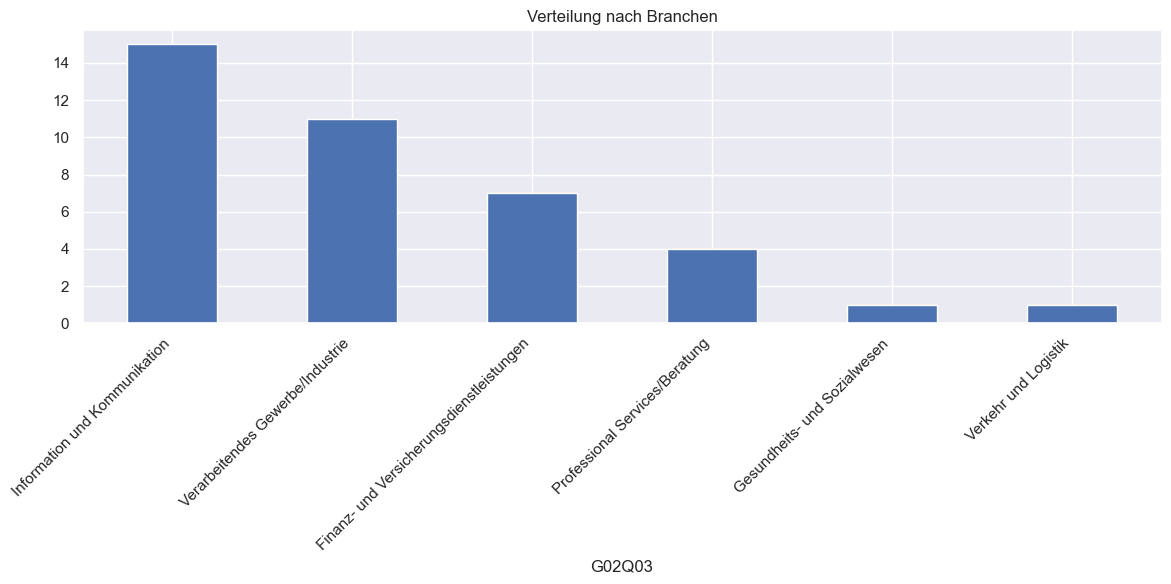

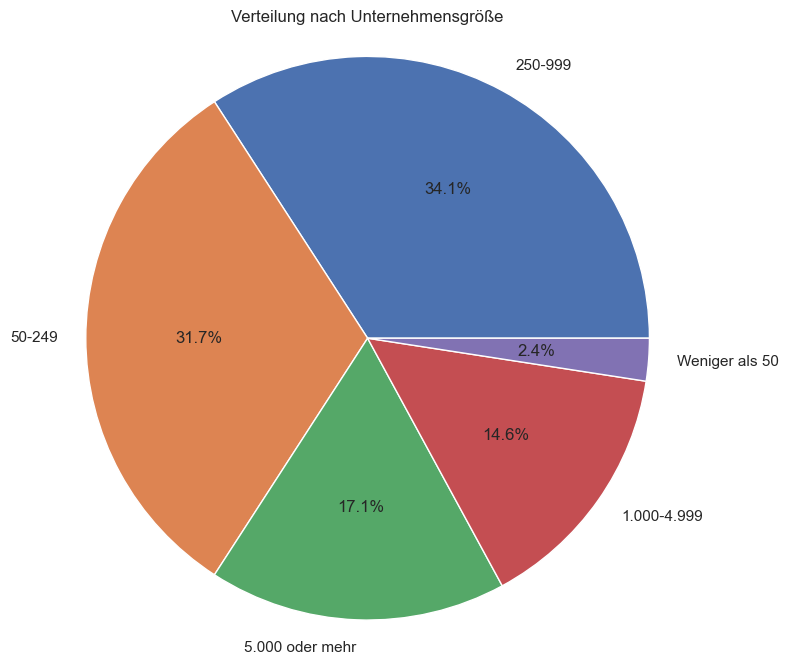

In [9]:
# Branchenverteilung
plt.figure(figsize=(12, 6))
branch_counts = relevant_data['G02Q03'].map(industry_mapping).value_counts()
branch_counts.plot(kind='bar')
plt.title('Verteilung nach Branchen')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Unternehmensgrößen
plt.figure(figsize=(8, 8))
size_counts = relevant_data['G02Q02'].map(size_mapping).value_counts()
plt.pie(size_counts, labels=size_counts.index, autopct='%1.1f%%')
plt.title('Verteilung nach Unternehmensgröße')
plt.axis('equal')
plt.show()

<Figure size 1200x600 with 0 Axes>

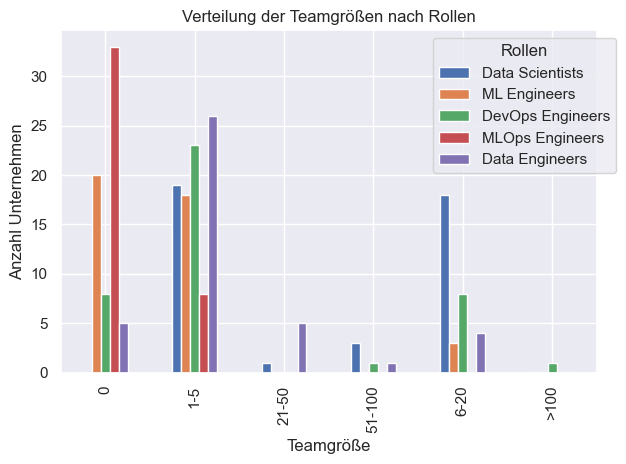

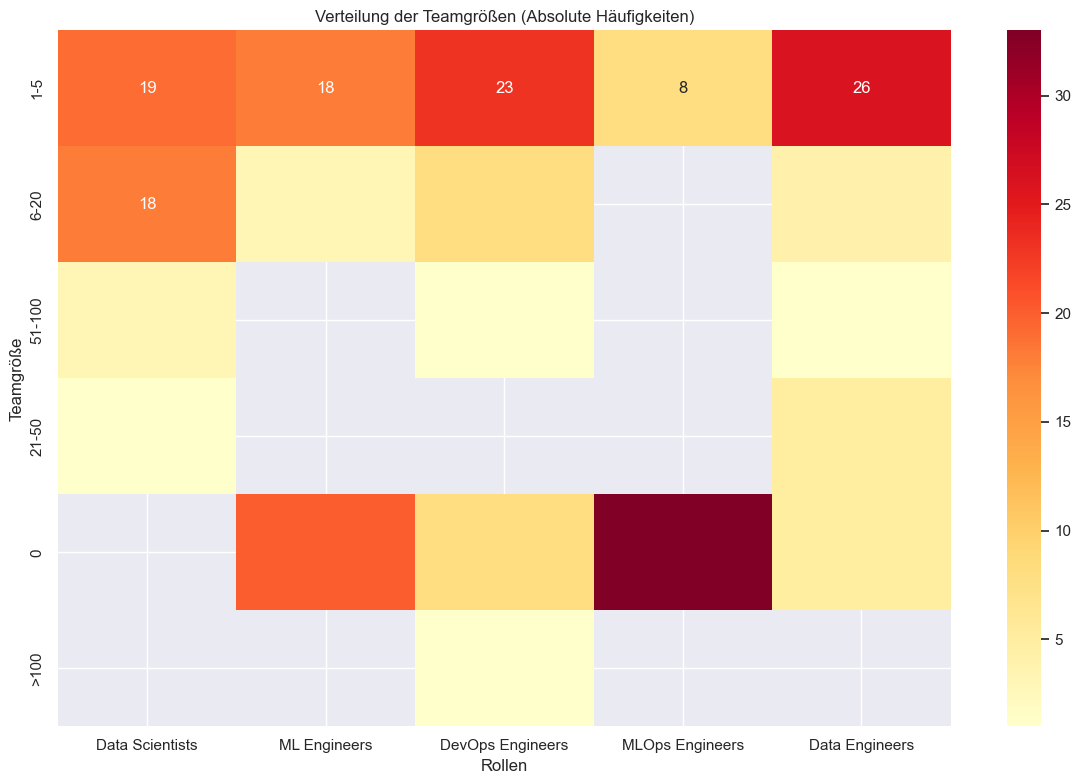

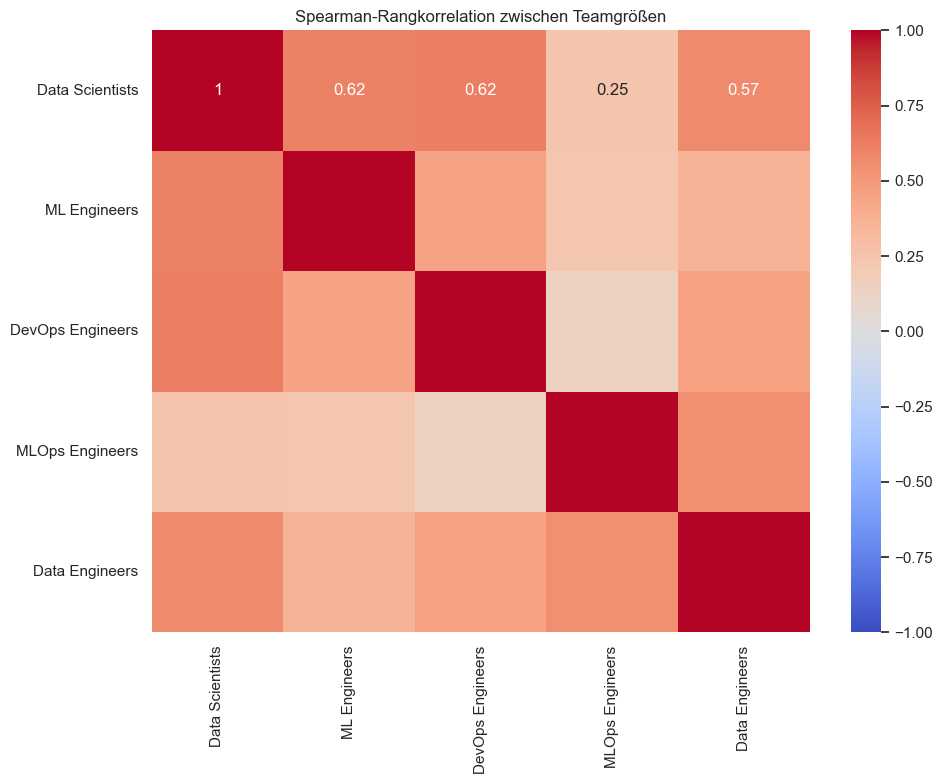

In [10]:
team_columns = ['G02Q05[SQ001]', 'G02Q05[SQ002]', 'G02Q05[SQ003]', 'G02Q05[SQ004]', 'G02Q05[SQ005]']
team_labels = ['Data Scientists', 'ML Engineers', 'DevOps Engineers', 'MLOps Engineers', 'Data Engineers']

# Visualisierung der Teamstruktur als gestapeltes Balkendiagramm
team_data_viz = relevant_data[team_columns].replace(team_size_mapping)

plt.figure(figsize=(12, 6))
team_data_plot = pd.DataFrame({
    label: team_data_viz[col].value_counts()
    for col, label in zip(team_columns, team_labels)
})
team_data_plot.plot(kind='bar', stacked=False)
plt.title('Verteilung der Teamgrößen nach Rollen')
plt.xlabel('Teamgröße')
plt.ylabel('Anzahl Unternehmen')
plt.legend(title='Rollen', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Heatmap der absoluten Häufigkeiten
plt.figure(figsize=(12, 8))
heatmap_data = pd.DataFrame([
    team_data_viz[col].value_counts()
    for col in team_columns
], index=team_labels).T
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='YlOrRd')
plt.title('Verteilung der Teamgrößen (Absolute Häufigkeiten)')
plt.xlabel('Rollen')
plt.ylabel('Teamgröße')
plt.tight_layout()
plt.show()

# Korrelationsanalyse mit numerischen Werten
team_data_corr = relevant_data[team_columns].replace(team_size_numeric)
plt.figure(figsize=(10, 8))
team_corr = team_data_corr.corr(method='spearman')
sns.heatmap(team_corr,
            annot=True,
            cmap='coolwarm',
            xticklabels=team_labels,
            yticklabels=team_labels,
            vmin=-1, vmax=1)
plt.title('Spearman-Rangkorrelation zwischen Teamgrößen')
plt.tight_layout()
plt.show()

## Hypothesenprüfung

Spearman-Korrelation

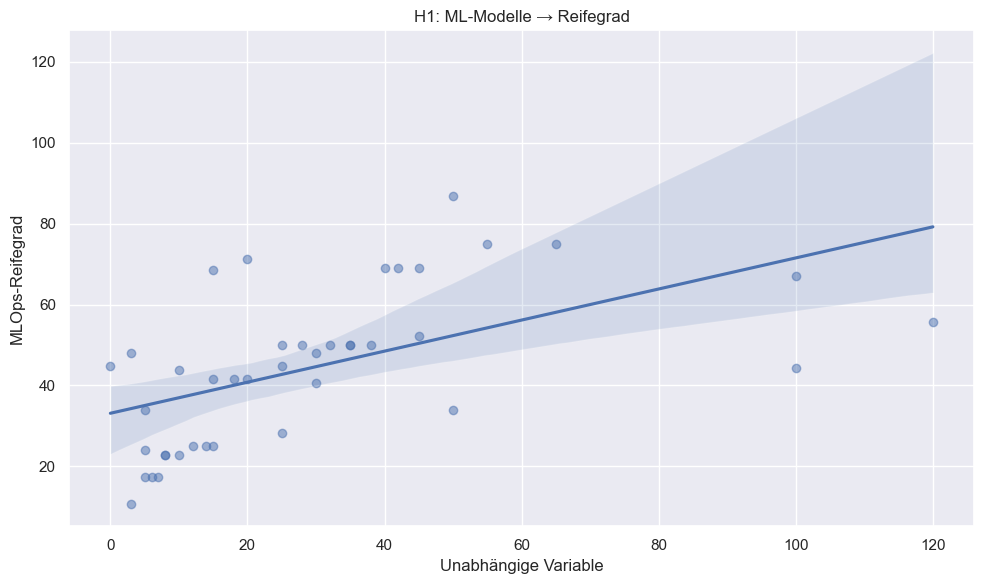

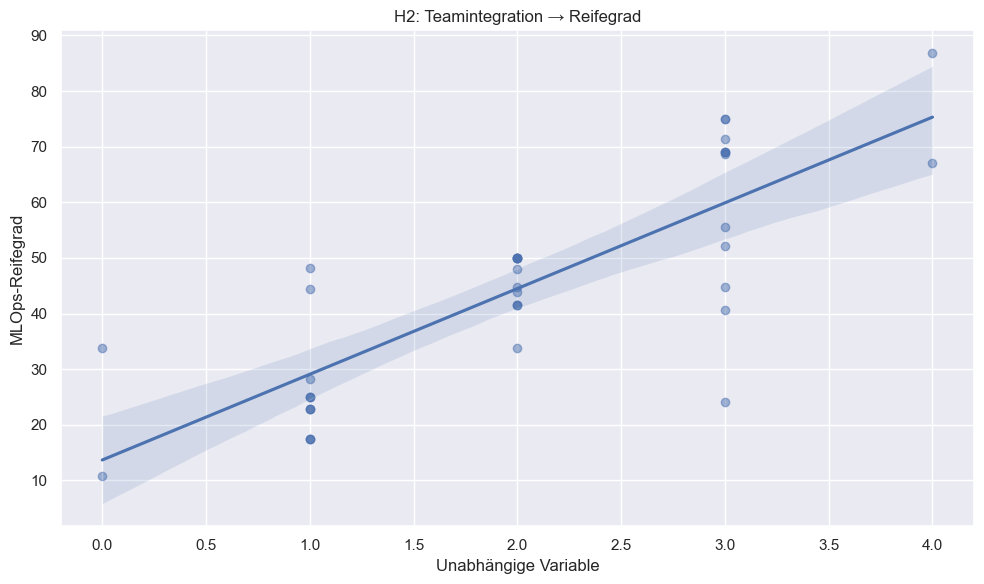

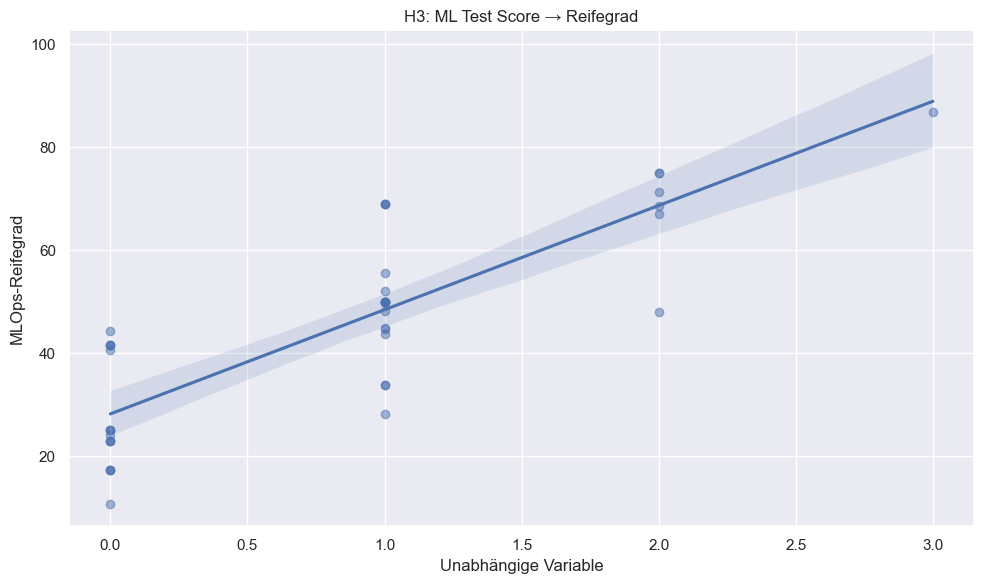


Ergebnisse der Hypothesenprüfung:
                      Hypothese  Korrelation       p-Wert  KI Untergrenze  KI Obergrenze Effektstärke  Signifikant (α=0.05)
     H1: ML-Modelle → Reifegrad     0.721660 1.014422e-07        0.532159       0.842303        stark                  True
H2: Teamintegration → Reifegrad     0.790119 8.117730e-10        0.637411       0.883104        stark                  True
  H3: ML Test Score → Reifegrad     0.833785 1.307370e-11        0.707659       0.908414        stark                  True


In [11]:
# Variablen vorbereiten
x1_ml_models = relevant_data['G02Q04'].astype(float)  # Direkte Konvertierung zu float
x2_team_integration = relevant_data['G03Q06'].replace(scale_mapping)


# ML Test Score nach Breck et al. (2017) berechnen
ml_test_columns = ['G04Q09', 'G04Q10', 'G04Q11', 'G04Q12']
ml_test_scores = relevant_data[ml_test_columns].replace(scale_mapping)
x3_test_score = ml_test_scores.min(axis=1)  # Minimum der vier Komponenten

y_maturity = relevant_data['Gesamtreifegrad']

# Hypothesentests durchführen
hypotheses = [
    ('H1: ML-Modelle → Reifegrad', x1_ml_models),
    ('H2: Teamintegration → Reifegrad', x2_team_integration),
    ('H3: ML Test Score → Reifegrad', x3_test_score)
]

results = []
for name, x in hypotheses:
    # Korrelation berechnen
    correlation, p_value = stats.spearmanr(x, y_maturity)
    ci_low, ci_high = calculate_confidence_interval(correlation, len(x))

    # Ergebnisse speichern
    results.append({
        'Hypothese': name,
        'Korrelation': correlation,
        'p-Wert': p_value,
        'KI Untergrenze': ci_low,
        'KI Obergrenze': ci_high,
        'Effektstärke': interpret_correlation(correlation),
        'Signifikant (α=0.05)': p_value < 0.05
    })

    # Visualisierung
    plot_correlation(x, y_maturity,
                    f'{name}',
                    'Unabhängige Variable',
                    'MLOps-Reifegrad')

# Ergebnisse anzeigen
results_df = pd.DataFrame(results)
print("\nErgebnisse der Hypothesenprüfung:")
print(results_df.to_string(index=False))

## Analyse der MLOps-Reifegrade

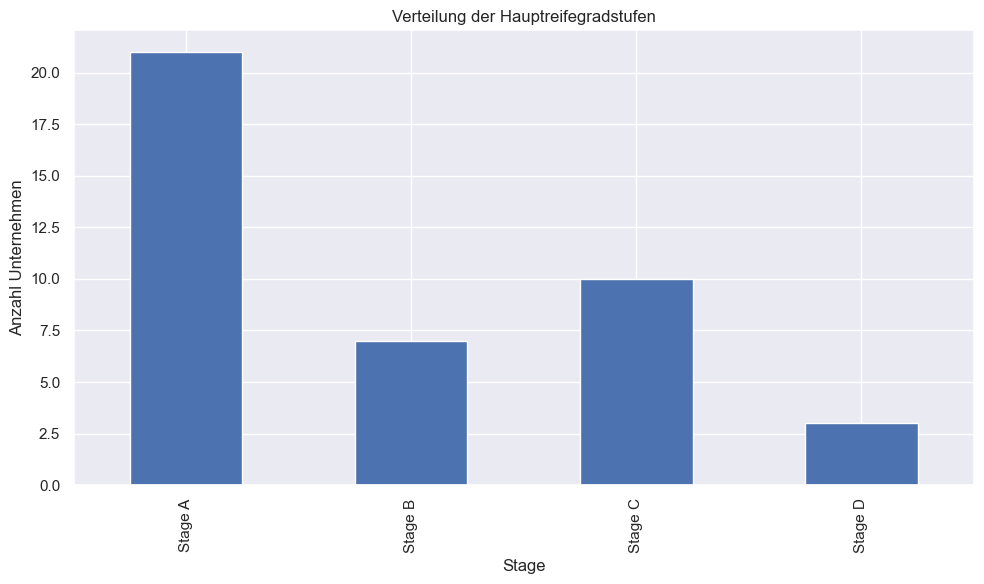

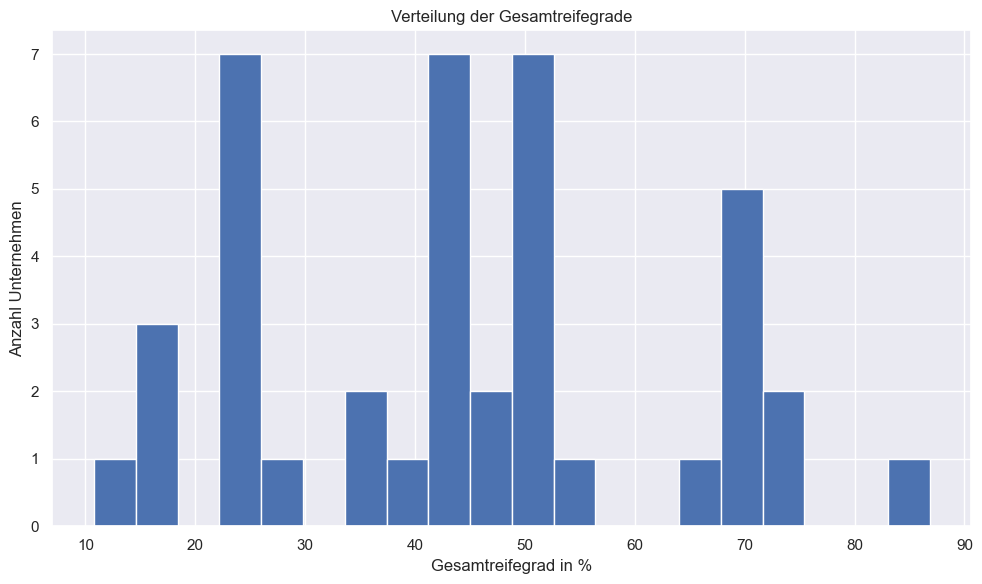


Deskriptive Statistiken:
count    41.00
mean     44.49
std      19.03
min      10.78
25%      25.00
50%      44.76
75%      52.14
max      86.84
Name: Gesamtreifegrad, dtype: float64


In [12]:
# Verteilung der Hauptreifegradstufen
# Erstelle die Reihenfolge der Stages
stage_order = ["Stage A", "Stage B", "Stage C", "Stage D"]

# Sortiere die Daten nach der definierten Reihenfolge
data_sorted = relevant_data['Hauptreifegradstufe'].value_counts().reindex(stage_order)
plt.figure(figsize=(10, 6))
data_sorted.plot(kind='bar')
plt.title('Verteilung der Hauptreifegradstufen')
plt.xlabel('Stage')
plt.ylabel('Anzahl Unternehmen')
plt.tight_layout()
plt.show()

# Verteilung der Gesamtreifegrade
plt.figure(figsize=(10, 6))
plt.hist(relevant_data['Gesamtreifegrad'], bins=20)
plt.title('Verteilung der Gesamtreifegrade')
plt.xlabel('Gesamtreifegrad in %')
plt.ylabel('Anzahl Unternehmen')
plt.tight_layout()
plt.show()

# Deskriptive Statistiken
print("\nDeskriptive Statistiken:")
print(relevant_data['Gesamtreifegrad'].describe().round(2))

## Explorative Analysen


Analyse nach Unternehmensgröße:
                   Mittlerer Reifegrad  Standardabweichung  Anzahl
Unternehmensgröße                                                 
1.000-4.999                      61.63               13.82       6
250-999                          51.91               10.39      14
5.000 oder mehr                  50.03               26.06       7
50-249                           25.91                8.16      13
Weniger als 50                   40.66                 NaN       1

Analyse nach Branche:
                                           Mittlerer Reifegrad  \
Branche                                                          
Finanz- und Versicherungsdienstleistungen                54.49   
Gesundheits- und Sozialwesen                             40.66   
Information und Kommunikation                            46.27   
Professional Services/Beratung                           24.22   
Verarbeitendes Gewerbe/Industrie                         40.62   
Verkehr und L

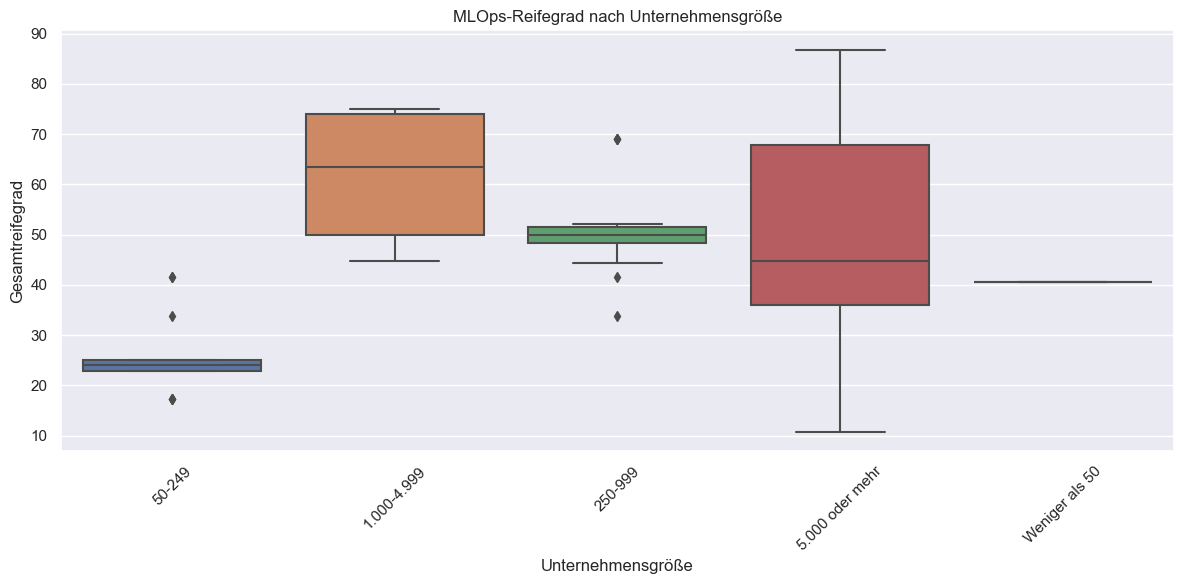

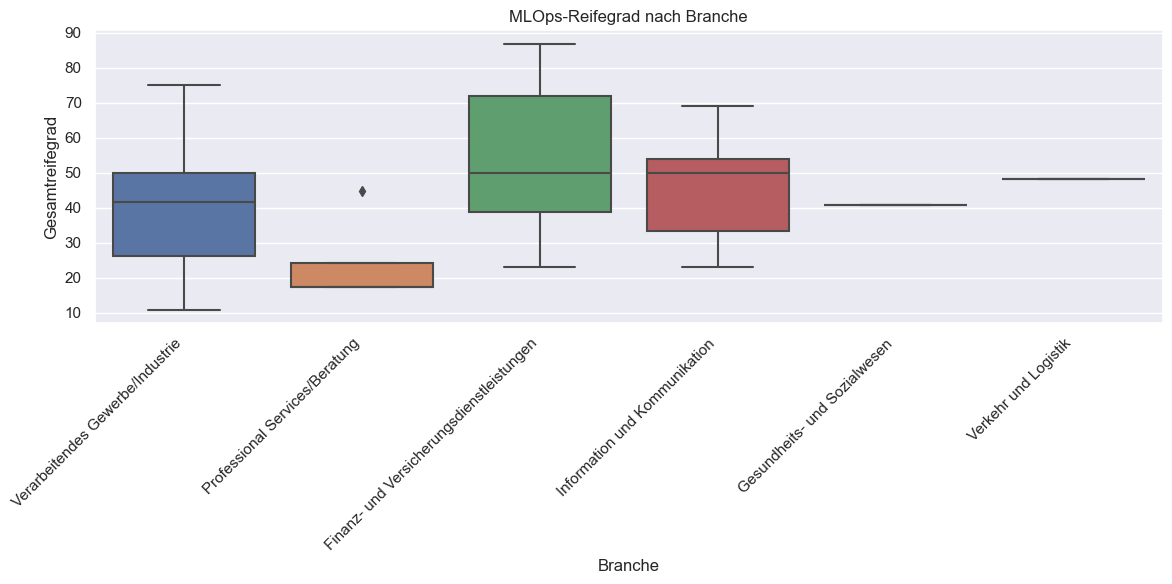

In [13]:
# Temporäre Spalten mit gemappten Werten erstellen - nutzt existierende Mappings
relevant_data['Unternehmensgröße'] = relevant_data['G02Q02'].map(size_mapping)
relevant_data['Branche'] = relevant_data['G02Q03'].map(industry_mapping)

# Analyse nach Unternehmensgröße
size_analysis = pd.DataFrame({
    'Mittlerer Reifegrad': relevant_data.groupby('Unternehmensgröße')['Gesamtreifegrad'].mean(),
    'Standardabweichung': relevant_data.groupby('Unternehmensgröße')['Gesamtreifegrad'].std(),
    'Anzahl': relevant_data.groupby('Unternehmensgröße')['Gesamtreifegrad'].count()
}).round(2)

print("\nAnalyse nach Unternehmensgröße:")
print(size_analysis)

# Analyse nach Branche
industry_analysis = pd.DataFrame({
    'Mittlerer Reifegrad': relevant_data.groupby('Branche')['Gesamtreifegrad'].mean(),
    'Standardabweichung': relevant_data.groupby('Branche')['Gesamtreifegrad'].std(),
    'Anzahl': relevant_data.groupby('Branche')['Gesamtreifegrad'].count()
}).round(2)

print("\nAnalyse nach Branche:")
print(industry_analysis)

# Visualisierung der Ergebnisse
plt.figure(figsize=(12, 6))
sns.boxplot(data=relevant_data, x='Unternehmensgröße', y='Gesamtreifegrad')
plt.title('MLOps-Reifegrad nach Unternehmensgröße')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=relevant_data, x='Branche', y='Gesamtreifegrad')
plt.title('MLOps-Reifegrad nach Branche')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Unterschiede zwischen Branchen und Reifegradstufen
Fragestellung: Gibt es signifikante Unterschiede zwischen den Branchen in Bezug auf die Verteilung der Hauptreifegradstufen?

In [14]:
# Kreuztabelle für Branchen und Hauptreifegradstufen
crosstab = pd.crosstab(relevant_data['Branche'], relevant_data['Hauptreifegradstufe'])
print("\nKreuztabelle Branche vs. Reifegradstufe:")
print(crosstab)

# Chi-Quadrat-Test
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f"\nChi-Quadrat-Test: χ² = {chi2:.2f}, p = {p:.4f}")


Kreuztabelle Branche vs. Reifegradstufe:
Hauptreifegradstufe                        Stage A  Stage B  Stage C  Stage D
Branche                                                                      
Finanz- und Versicherungsdienstleistungen        4        1        1        1
Gesundheits- und Sozialwesen                     0        1        0        0
Information und Kommunikation                    8        2        4        1
Professional Services/Beratung                   1        0        3        0
Verarbeitendes Gewerbe/Industrie                 6        2        2        1
Verkehr und Logistik                             1        0        0        0

Chi-Quadrat-Test: χ² = 12.94, p = 0.6071


### Einfluss der Unternehmensgröße auf die Reifegradstufen
Fragestellung: Unterscheiden sich kleinere Unternehmen systematisch in ihren Hauptreifegradstufen von größeren Unternehmen?

In [15]:
# ANOVA-Test für Unternehmensgröße und Gesamtreifegrad
anova_result = stats.f_oneway(
    relevant_data[relevant_data['Unternehmensgröße'] == '50-249']['Gesamtreifegrad'],
    relevant_data[relevant_data['Unternehmensgröße'] == '250-999']['Gesamtreifegrad'],
    relevant_data[relevant_data['Unternehmensgröße'] == '1.000-4.999']['Gesamtreifegrad'],
    relevant_data[relevant_data['Unternehmensgröße'] == '5.000 oder mehr']['Gesamtreifegrad']
)
print(f"\nANOVA-Test: F = {anova_result.statistic:.2f}, p = {anova_result.pvalue:.4f}")


ANOVA-Test: F = 12.00, p = 0.0000
